# Coastal Simulation Notebook

This Jupyter Notebook simulates the interaction between terrain, sand, and water along a coastline. The simulation models the effects of waves on the coastline, including the movement of sand and the erosion of terrain. The key components of the simulation include:

- **Terrain, Sand, and Water Mapping**: The coastline is represented as a 2D grid where each cell can be terrain, sand, or water.
- **Wave Generation and Movement**: Waves are generated periodically and move across the coastline, affecting the distribution of sand and terrain.
- **Sand and Terrain Interaction**: The interaction between sand and terrain is modeled to simulate natural processes such as erosion and deposition.
- **Visualization**: The state of the coastline is visualized at each timestep to observe the changes over time.

The notebook includes functions to initialize the coastline, generate waves, move sand, and display the coastline. The simulation parameters such as wave frequency, speed, and decay can be adjusted to observe different behaviors.

In [66]:
import numpy as np
import random
import copy
import cv2 as cv
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
import time

In [67]:
def white_kernel(x1, x2, varSigma):
    if x2 is None:
        return varSigma*np.eye(x1.shape[0])
    else:
        return np.zeros(x1.shape[0], x2.shape[0])
    
def periodic_kernel(x1, x2, varSigma, period, lengthScale):
    if x2 is None:
        d = cdist(x1, x1)
    else:
        d = cdist(x1, x2)
    return varSigma*np.exp(-(2*np.sin((np.pi/period)*d)**2)/lengthScale**2)

def get_coast_noise(scaling_factor=3, period=1, noise_level=0.01):
    x = np.linspace(0,DIM_MAP, DIM_MAP).reshape(-1,1)
    K = periodic_kernel(x,x,1,period,1) + white_kernel(x,None,noise_level)
    mu = np.zeros(x.shape)
    
    f = scaling_factor* np.random.multivariate_normal(mu.flatten(), K, 1)[0]
    return f

In [68]:
GROUND_COLOR = [34, 139, 34]  # Forest Green
SAND_COLOR = [244, 164, 96]   # Sandy Brown
WATER_COLOR = [30, 144, 255]  # Dodger Blue
FRAC_GROUND, FRAC_SAND = 0.3, 0.3
DIM_MAP = 100

WAVE_FREQ = 20
WAVE_SPEED = 1
WAVE_DECAY = 0.6
WAVE_CUTOFF = 0.1
WAVE_RETREAT_COEFF = 0.8
WAVE_HEIGHT = 2

SAND_PULL = 0.2
GROUND_PULL = 0.1
WATER_DECAY = 0.99

GROUND_COLOR.reverse()
SAND_COLOR.reverse()
WATER_COLOR.reverse()

Mapping

0 - Terrain (solid ground, terrain)

1 - Sand (loose sand)

2 - Water

3 - Solid Objects ? 

### Function: display_map

The `display_map` function visualizes the current state of the coastline simulation. It takes the following parameters:

- `coast`: A 3D numpy array representing the coastline, where each cell contains values for terrain, sand, and water.
- `waves_inp` (optional): A list of wave positions to be displayed on the map.
- `waves_pos` (optional): A list of wave positions to be displayed on the map.
- `stream` (optional, default=True): A boolean indicating whether to stream the visualization using OpenCV.
- `openCV` (optional, default=False): A boolean indicating whether to use OpenCV for visualization.

The function creates an image where different colors represent terrain, sand, and water. If `waves_inp` is provided, it overlays the wave positions on the map. The function can display the map using either Matplotlib or OpenCV, depending on the `openCV` parameter.

In [69]:
def display_map(coast, waves_inp=[], waves_pos=[], stream=True, openCV=False):
    global GROUND_COLOR, SAND_COLOR, WATER_COLOR
    
    cv.namedWindow("Coast")
    
    img = np.zeros((coast.shape[0], coast.shape[1],3), dtype=int)
    coast_temp = copy.deepcopy(coast)
    coast_temp[:,:,0] = (coast_temp[:,:,0] / np.max(coast_temp[:,:,0])) * 255
    coast_temp[:,:,1] = (coast_temp[:,:,1] / np.max(coast_temp[:,:,1])) * 255
    coast_temp[:,:,2] = (coast_temp[:,:,2] / np.max(coast_temp[:,:,2])) * 255
    coast_temp = coast_temp[...,np.newaxis]
    img = np.array(GROUND_COLOR).reshape(1,1,-1)*coast_temp[:,:,0,:]   ## Ground Color
    img+= np.array(SAND_COLOR).reshape(1,1,-1)*coast_temp[:,:,1,:]   ## Sand Color
    img+= np.array(WATER_COLOR).reshape(1,1,-1)*coast_temp[:,:,2,:]   ## Water Color
    

    if len(waves_inp) > 0:
        for i in range(DIM_MAP):
            img[i,waves_inp[:,i]] = [0,0,255]

    if not openCV:
        plt.imshow(img)
        plt.show()

    if openCV:
        img = img.astype(np.uint8)
        img_cv = cv.cvtColor(img, cv.COLOR_RGB2BGR)
        img_cv = cv.resize(img_cv, (1000,1000))
        
        cv.imshow("Coast", img_cv)
        if stream:
            cv.waitKey(2)
        else:
            cv.waitKey(0)
            cv.destroyWindow("Coast")
            cv.waitKey(1)

In [70]:
coast_map = np.zeros((DIM_MAP, DIM_MAP,3), dtype=np.int16)

In [71]:
coast_map[:,:int(DIM_MAP*FRAC_GROUND),0] = 100  ## Assign sand portion of the map
coast_map[:,int(DIM_MAP*FRAC_GROUND):int(DIM_MAP*(FRAC_GROUND+FRAC_SAND)),1] = 100  ## Assign sand portion of the map
coast_map[:,int(DIM_MAP*(FRAC_GROUND+FRAC_SAND)):, 2] = 100  ## Assign water portion of the map

-ve -> Push water towards sand


+ve -> Push sand towards water

In [72]:
rand_coast = get_coast_noise(scaling_factor=DIM_MAP / 20, period=0.5, noise_level=1 / DIM_MAP)
rand_terrain = get_coast_noise(scaling_factor=DIM_MAP/20, period=0.5, noise_level=1 / DIM_MAP)

In [73]:
def get_coast(coast_inp):
    temp_coast = copy.deepcopy(coast_inp)

    for i in range(len(rand_coast)):
        if rand_coast[i] < 0:
            temp_coast[i, int(DIM_MAP*(FRAC_GROUND+FRAC_SAND))+int(rand_coast[i]):,2] = 100
            temp_coast[i, int(DIM_MAP*(FRAC_GROUND+FRAC_SAND))+int(rand_coast[i]):,1] = 0
        else:
            temp_coast[i, int(DIM_MAP*(FRAC_GROUND+FRAC_SAND)):int(rand_coast[i])+int(DIM_MAP*(FRAC_GROUND+FRAC_SAND)), 1] = 100
            temp_coast[i, int(DIM_MAP*(FRAC_GROUND+FRAC_SAND)):int(rand_coast[i])+int(DIM_MAP*(FRAC_GROUND+FRAC_SAND)), 2] = 0
    
        if rand_terrain[i] < 0:
            temp_coast[i, int(DIM_MAP*(FRAC_GROUND))+int(rand_terrain[i]):int(DIM_MAP*(FRAC_GROUND+FRAC_SAND)), 1] = 100
            temp_coast[i, int(DIM_MAP*(FRAC_GROUND))+int(rand_terrain[i]):int(DIM_MAP*(FRAC_GROUND+FRAC_SAND)), 0] = 0
        else:
            temp_coast[i, :int(DIM_MAP*(FRAC_GROUND))+int(rand_terrain[i]), 0] = 100
            temp_coast[i, :int(DIM_MAP*(FRAC_GROUND))+int(rand_terrain[i]), 1] = 0
    return temp_coast

In [74]:
def move_sand(coast_inp, waves, pos, wave_speeds):
    global WAVE_DECAY, SAND_PULL, GROUND_PULL, WAVE_CUTOFF, WAVE_RETREAT_COEFF

    
    waves = calculate_wave_pos(waves, pos)
    for wave_idx in range(len(waves)):
        for i in range(len(waves[0])):
            vert_idx = i 
            hor_idx = waves[0][i]
            curr_pix = coast_inp[vert_idx, hor_idx]
            if wave_speeds[wave_idx][i] > WAVE_CUTOFF:
                left_pix = coast_inp[vert_idx,hor_idx-1]
                if left_pix[0] == 0 and left_pix[1] == 0:
                    continue
                
                wave_speeds[wave_idx][i] *= WAVE_DECAY
                if wave_speeds[wave_idx][i] < 0.1:
                    wave_speeds[wave_idx][i] = -1
                    continue
                new_curr_pix = copy.deepcopy(curr_pix)
                new_curr_pix[0] = curr_pix[0] - curr_pix[0]* GROUND_PULL*wave_speeds[wave_idx][i]
                new_curr_pix[1] = curr_pix[1] - curr_pix[1]* SAND_PULL*wave_speeds[wave_idx][i]
                new_curr_pix[2] = curr_pix[2] - curr_pix[2] * WATER_DECAY
                coast_inp[vert_idx, hor_idx] = new_curr_pix
                
                
                left_pix[0] = left_pix[0] + curr_pix[0]* GROUND_PULL*wave_speeds[wave_idx][i]
                left_pix[1] = left_pix[1] + curr_pix[1]* SAND_PULL*wave_speeds[wave_idx][i]
                left_pix[2] = left_pix[2] + curr_pix[2] * WATER_DECAY
                coast_inp[vert_idx, hor_idx-1] = left_pix

            
            elif wave_speeds[wave_idx][i] < 0:
                if curr_pix[0] == 0 and curr_pix[1] == 0 and curr_pix[2] > 1:
                    wave_speeds[wave_idx][i] == 0
                    continue
                right_pix = coast_inp[vert_idx, hor_idx+1]
                # print(right_pix)
                # print(curr_pix)
                # if right_pix[0] == 0 and right_pix[1] == 0 and right_pix[2] == 1:
                #     ## There is no sand or ground to the right/ Ocean / End the wave
                #     wave_speeds[wave_idx][i] == 0
                #     continue
                # print("RETREAT WAVE")
                new_curr_pix = copy.deepcopy(curr_pix)
                new_curr_pix[0] = curr_pix[0] - WAVE_RETREAT_COEFF * curr_pix[0]*GROUND_PULL*wave_speeds[wave_idx][i]
                new_curr_pix[1] = curr_pix[1] - WAVE_RETREAT_COEFF * curr_pix[1]*SAND_PULL*wave_speeds[wave_idx][i]
                new_curr_pix[2] = curr_pix[2] - WAVE_RETREAT_COEFF * curr_pix[2] * WATER_DECAY
                
                right_pix[0] = right_pix[0] + WAVE_RETREAT_COEFF * curr_pix[0]*GROUND_PULL*wave_speeds[wave_idx][i]
                right_pix[1] = right_pix[1] + WAVE_RETREAT_COEFF * curr_pix[1]*SAND_PULL*wave_speeds[wave_idx][i]
                right_pix[2] = right_pix[2] + WAVE_RETREAT_COEFF * curr_pix[2] * WATER_DECAY

                coast_inp[vert_idx, hor_idx] = new_curr_pix
                coast_inp[vert_idx, hor_idx+1] = right_pix
                
                wave_speeds[wave_idx][i] *= WAVE_DECAY
        # print("MOVED_WAVE")
    return coast_inp

In [75]:
def calculate_wave_pos(waves, pos):
    return np.clip(np.add(waves,pos),0,DIM_MAP-1).astype(np.int16)

def run_sim(num_timesteps, plots=False):
    global WAVE_FREQ, WAVE_SPEED, coast_map

    temp_coast_map = get_coast(coast_map)
    waves = np.array([get_coast_noise(scaling_factor=10, period=0.5, noise_level=1/DIM_MAP).astype(np.int16)])
    pos = np.array([np.ones(waves[0].shape) * DIM_MAP])
    wave_speeds = np.array([np.ones(waves[0].shape) * WAVE_SPEED])

    
    for t in range(1,num_timesteps):
        if t%WAVE_FREQ == 0:
            new_wave = get_coast_noise(scaling_factor=10, period=0.5, noise_level=1/DIM_MAP).astype(np.int16).reshape(1,-1)
            waves = np.append(waves, new_wave, axis=0)
            pos = np.append(pos,np.ones(new_wave.shape) * DIM_MAP, axis=0)
            wave_speeds = np.append(wave_speeds, np.array([np.ones(waves[0].shape) * WAVE_SPEED]), axis=0)

            if plots:
                display_map(temp_coast_map, calculate_wave_pos(waves, pos))
        temp_coast_map = move_sand(temp_coast_map, waves, pos, wave_speeds)
        pos = pos - wave_speeds
        if plots:
            display_map(temp_coast_map, calculate_wave_pos(waves, pos), openCV=False)
        
        # time.sleep(0.5)
    return temp_coast_map

In [76]:
ret = run_sim(200)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-36..197].


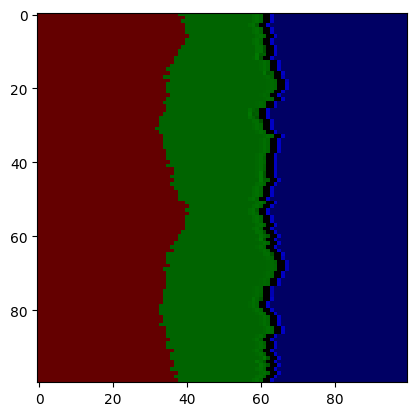

In [77]:
plt.imshow(ret)

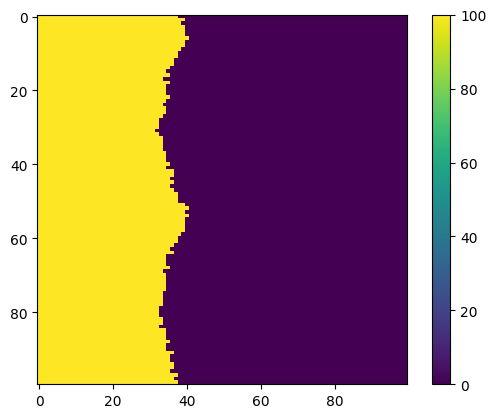

In [78]:
plt.imshow(ret[:,:,0])
plt.colorbar()

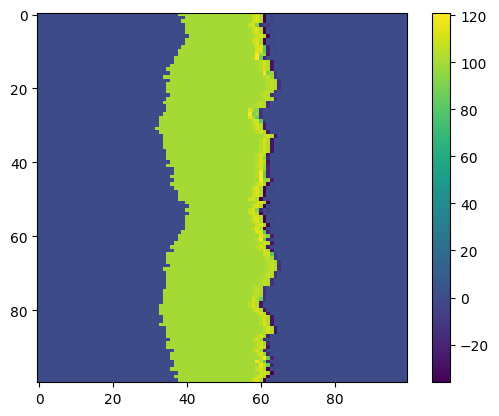

In [79]:
plt.imshow(ret[:,:,1])
plt.colorbar()

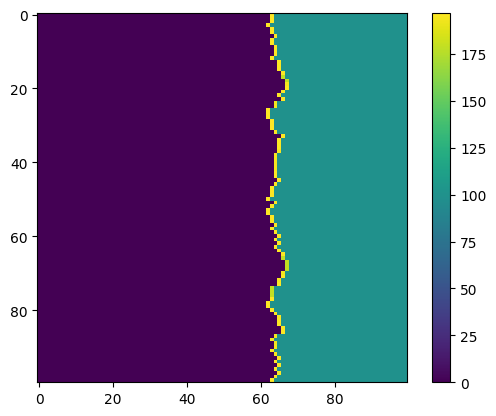

In [80]:
plt.imshow(ret[:,:,2])
plt.colorbar()